<a href="https://colab.research.google.com/github/JDS289/BaLD4LLM/blob/main/proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using GPU seems to sometimes cause a CUDA error; using TPU seems to sometimes cause "Unknown crash".
CPU takes approximately 10x longer than GPU.


3B has said False to "Paris is the capital of France". Might want to use 8B instead. For now, I'll continue to use 3B for speed/simplicity. This is also justified for "reproducibility" reasons, though if accuracy is negligible then switch to a better model.

8B works with TPU? (sample size 1)
but still insanely slow - hasn't yet answered a single prompt (i think it may have gotten one or two, but i don't remember)

AHH it turns out 3B is good with low temperature.

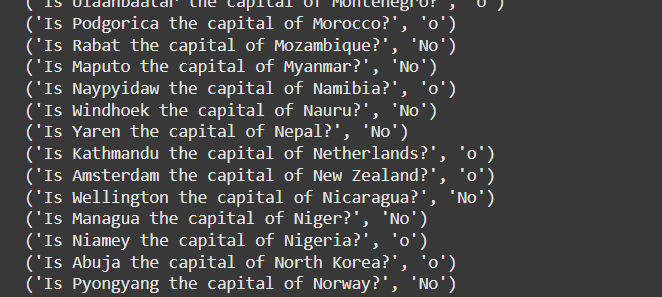

In [ ]:
# Not sure why it's saying 'o'.  Maybe I limited generation-length too much or something?

Actually, it looks like I may never actually need the responses. But maybe it could be interesting to see whether its wrong answers show anything interesting in activations? (or e.g. do bayesian inference rn to get a confidence)

In [75]:
import os
import numpy as np
from tqdm.notebook import tqdm
from google.colab import userdata
from matplotlib import pyplot as plt
from math import exp
import requests
import torch
from huggingface_hub import login
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [2]:
login(token=userdata.get("huggingface_secret"))

device = "cuda" if torch.cuda.is_available() else "cpu"
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

MODEL_NAME = ["meta-llama/Llama-3.1-8B-Instruct", "meta-llama/Llama-3.2-3B-Instruct"][1]
SYS_PROMPT = ""

accelerator = Accelerator()

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    device_map="auto",
    output_hidden_states=True,
    return_dict_in_generate=True,
)

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [30]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_safetensors=True)
tokenizer.padding_side = "left"
assert str(tokenizer.added_tokens_decoder[128002]) == "<|reserved_special_token_0|>"
tokenizer.pad_token = str(tokenizer.added_tokens_decoder[128002])
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
model, tokenizer = accelerator.prepare(model, tokenizer)

model.generation_config.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# check if the following are necessary etc
model.generation_config.output_hidden_states = True
model.generation_config.return_dict_in_generate = True
model.generation_config.output_logits = True

In [106]:
def process_chunk(text_chunk_batch, layer=12, return_top_prob=False):
    def strip_text(text, prompt):
        after_prompt = text[text.index(prompt) + len(prompt) :]
        header = "<|start_header_id|>assistant<|end_header_id|>"
        return after_prompt[after_prompt.index(header) + len(header) :].lstrip()

    if type(text_chunk_batch) == str:
        print('Please use "[string]" as `text_chunk_batch` (make a singleton list).')
        return False

    conversations = [[{"role": "user", "content": text_chunk}] for text_chunk in text_chunk_batch]

    prompts = tokenizer.apply_chat_template(conversations, tokenize=False)
    inputs = tokenizer(prompts, padding="max_length", padding_side="left", max_length=64, return_tensors="pt")

    with torch.no_grad():
        inputs = inputs.to(accelerator.device)

        output = model.generate(
            **inputs,
            top_k=1,  # always most probable word (rather than softmaxing), as this is all we need for now
            max_new_tokens=5
        )
        # For answering yes/no questions like the following, very low temperature and max_new_tokens makes sense.
        # For this actual task its generations are not actually relevant, but they're helpful to see, and might be useful later.

        sequences, hidden_states, logits = output.sequences, output.hidden_states, output.logits[-1]
        softmaxed_logits = torch.softmax(logits, dim=-1)
        top_prob = torch.max(softmaxed_logits, dim=-1).values.cpu().numpy()

        processed_texts = tokenizer.batch_decode(sequences, skip_special_tokens=False) # without capping new_tokens, there might be "<|eot_id|>" at the end
        stripped_texts = [strip_text(text, prompt) for text, prompt in zip(processed_texts, prompts)]

        if type(text_chunk_batch) == str:
            tuple_to_return = text_chunk_batch, stripped_texts, hidden_states
        else:
            tuple_to_return = tuple(zip(text_chunk_batch, stripped_texts, np.array([tensor[-1].float().cpu() for tensor in hidden_states[0][layer]])))

        if return_top_prob:
            tuple_to_return += (top_prob,)

        return tuple_to_return

In [ ]:
capitals = requests.get("https://raw.githubusercontent.com/JDS289/BaLD4LLM/refs/heads/main/country-list.csv")
capitals_dict = {}
for string in capitals.content.decode('utf-8').split('\n')[1 : -1]:
  _, country, _, city, _ = string.split('"')
  capitals_dict[country] = city

print(capitals_dict)

{'Afghanistan': 'Kabul', 'Albania': 'Tirana', 'Algeria': 'Algiers', 'Andorra': 'Andorra la Vella', 'Angola': 'Luanda', 'Antigua and Barbuda': "St. John's", 'Argentina': 'Buenos Aires', 'Armenia': 'Yerevan', 'Australia': 'Canberra', 'Austria': 'Vienna', 'Azerbaijan': 'Baku', 'Bahamas': 'Nassau', 'Bahrain': 'Manama', 'Bangladesh': 'Dhaka', 'Barbados': 'Bridgetown', 'Belarus': 'Minsk', 'Belgium': 'Brussels', 'Belize': 'Belmopan', 'Benin': 'Porto-Novo', 'Bhutan': 'Thimphu', 'Bosnia and Herzegovina': 'Sarajevo', 'Botswana': 'Gaborone', 'Brazil': 'Brasília', 'Brunei': 'Bandar Seri Begawan', 'Bulgaria': 'Sofia', 'Burkina Faso': 'Ouagadougou', 'Burundi': 'Bujumbura', 'Cambodia': 'Phnom Penh', 'Cameroon': 'Yaoundé', 'Canada': 'Ottawa', 'Cape Verde': 'Praia', 'Central African Republic': 'Bangui', 'Chad': "N'Djamena", 'Chile': 'Santiago', 'China': 'Beijing', 'Colombia': 'Bogotá', 'Comoros': 'Moroni', 'Costa Rica': 'San José', 'Croatia': 'Zagreb', 'Cuba': 'Havana', 'Cyprus': 'Nicosia', "Côte d'Ivo

In [ ]:
MODE = "questions"

if MODE == "statements":
  true_list = [f"{capital} is the capital of {country}." for country, capital in capitals_dict.items()]
  fixed_order_capitals_dict = list(capitals_dict.items())
  false_list = [f"{fixed_order_capitals_dict[i][1]} is the capital of {fixed_order_capitals_dict[(i+1) % len(capitals_dict)][0]}." for i in range(len(capitals_dict))]

  results_true = [(q,) + process_chunk(q) for q in tqdm(true_list)]
  results_false = [(q,) + process_chunk(q) for q in tqdm(false_list)]

elif MODE == "questions":
  true_list = [f"Is {capital} the capital of {country}? (Yes/No) " for country, capital in capitals_dict.items()]
  fixed_order_capitals_dict = list(capitals_dict.items())
  false_list = [f"Is {fixed_order_capitals_dict[i][1]} is the capital of {fixed_order_capitals_dict[(i+1) % len(capitals_dict)][0]}? (Yes/No) " for i in range(len(capitals_dict))]

  def print_return(triple):
    print(triple[:2])
    return triple

  results_true = process_chunk(true_list)
  results_false = process_chunk(false_list)

In [109]:
import pickle

with open("/content/drive/My Drive/hidden_statess/question_results_true.pkl", "rb") as f:
  results_true = pickle.load(f)

with open("/content/drive/My Drive/hidden_statess/question_results_false.pkl", "rb") as f:
  results_false = pickle.load(f)


def to_tuples(array):
    """Deep conversion from numpy array (or list) to tuple. Input must be numpy.ndarray or List at all but final depth.
       No sub-iterables allowed except ndarray, List, and string (though the latter is not treated as such)."""
    if type(array) in {np.ndarray, list}:
        return tuple(to_tuples(i) for i in array)
    elif hasattr(array, "__iter__") and not isinstance(array, str):
        raise ValueError("Input must be numpy array or List at all but final depth.")
    return array

states_true = np.array([r[2] for r in results_true])
states_false = np.array([r[2] for r in results_false])
assert all([len(states_true.shape)==len(states_false.shape)==2, states_true.shape[1]>0, states_false.shape[1]>0, states_true.shape[1]==states_false.shape[1]])
NUM_ACTIVATIONS = states_true.shape[1]

def check_shape(arr):
    if len(arr) == 0:
        arr = arr.reshape(0, NUM_ACTIVATIONS)
    else:
        assert arr.shape[1] == NUM_ACTIVATIONS
    return arr

states_true_positive = check_shape(np.array([r[2] for r in results_true if r[1]=="Yes"]))
states_true_negative = check_shape(np.array([r[2] for r in results_false if r[1]=="No"]))
states_false_positive = check_shape(np.array([r[2] for r in results_false if r[1]=="Yes"]))
states_false_negative = check_shape(np.array([r[2] for r in results_true if r[1]=="No"]))

states_positive = np.concatenate([states_true_positive, states_false_positive])
states_negative = np.concatenate([states_true_negative, states_false_negative])
states_correct = np.concatenate([states_true_positive, states_true_negative])
states_incorrect = np.concatenate([states_false_positive, states_false_negative])

states_neither = np.array([r[2] for r in results_true+results_false if r[1] not in ["Yes", "No"]])
assert len(states_neither) == 0  # if this starts throwing, consider using .title() and stripping full stops etc
assert len(states_true) == len(states_false)

true_average = np.mean(states_true, axis=0)
false_average = np.mean(states_false, axis=0)
truth_direction = true_average - false_average
true_false_center = (true_average + false_average) / 2


assert len(states_true_positive) + len(states_true_negative) + len(states_false_negative) + len(states_false_positive) == len(results_true) + len(results_false)

def internal_trueness(activations):
    """For either 1d or 2d array `activations`."""
    return np.dot(activations-true_false_center, truth_direction)

def mean_trueness(activations):
    """For 2d array `activations`."""
    return float(np.mean(internal_trueness(activations)))

print(f"Average 'Internal Trueness' given true and correct (True Positive): {round(mean_trueness(states_true_positive), 5)}")
print(f"Average 'Internal Trueness' given true and incorrect (False Negative): {round(mean_trueness(states_false_negative), 5)}")
print(f"Average 'Internal Trueness' given false and correct (True Negative): {round(mean_trueness(states_true_negative), 5)}")
if len(states_false_positive):
    print(f"Average 'Internal Trueness' given false and incorrect (False Positive): {round(mean_trueness(states_false_positive), 5)}")
else:
    print("All false questions identified as such; no False Positives.")
    # This could be in part that the LLM has poorly-calibrated sensitivity/specificity;
    # but also remember that the capitals were simply rotated, so you would expect most of these to be obviously false.

Average 'Internal Trueness' given true and correct (True Positive): 9.02204
Average 'Internal Trueness' given true and incorrect (False Negative): 5.45955
Average 'Internal Trueness' given false and correct (True Negative): -8.43147
All false questions identified as such; no False Positives.


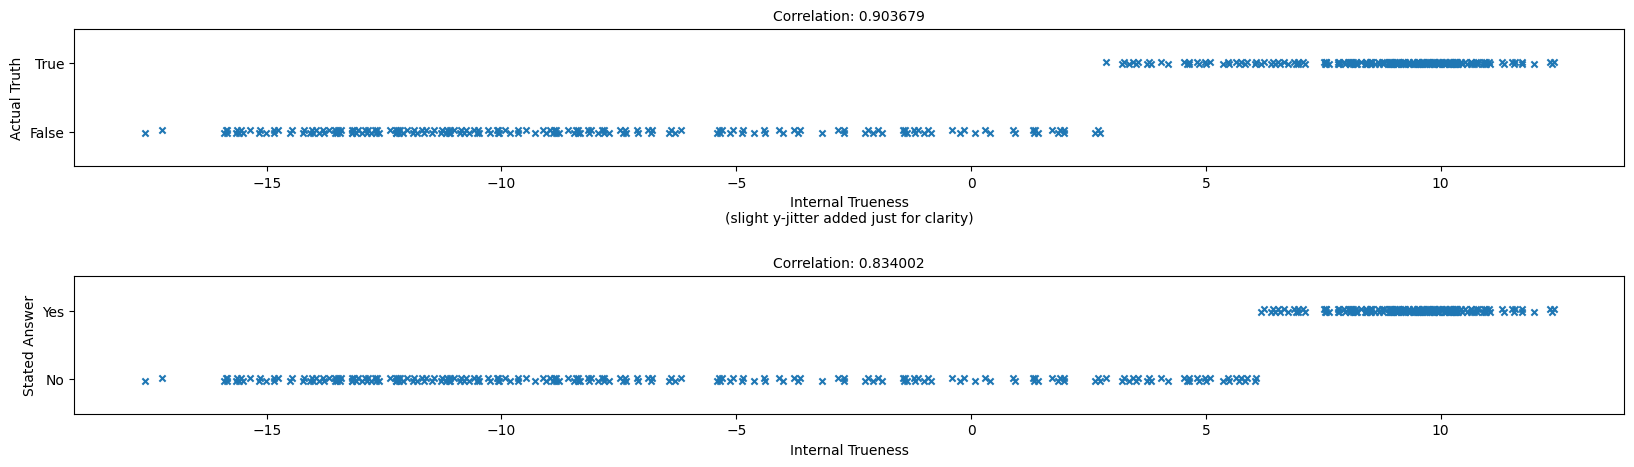

In [128]:
def scatter(ax, predictions, actual, xlabel="", ylabel="", **kwargs):
    """`predictions` and `actual` should be numpy arrays."""
    ax.scatter(predictions, actual, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Correlation: {round(pearsonr(predictions, actual)[0], 6)}", fontsize=10)
    return None  # now ending a Colab code block with scatter(...) avoids an excessive print


internal_vs_actual_truth = np.concatenate([np.column_stack([internal_trueness(states_false), np.zeros(len(states_false))]),
                                           np.column_stack([internal_trueness(states_true), np.ones(len(states_true))])])

internal_vs_actual_truth.sort(axis=0)

# `stated` refers to whether the LLM output "Yes" or "No". Because temperature is very low, this is approximately equal to the argmax of its distribution.
# bear in mind that the word "states" is the noun, not the verb.
internal_vs_stated = np.concatenate([np.column_stack([internal_trueness(states_negative), np.zeros(len(states_negative))]),
                                     np.column_stack([internal_trueness(states_positive), np.ones(len(states_positive))])])
internal_vs_stated.sort(axis=0)


fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 5))
plt.subplots_adjust(hspace=0.8)

ax1.set_yticks([0, 1], labels=["False", "True"])
ax1.set_ylim([-0.5, 1.5])
ax2.set_yticks([0, 1], labels=["No", "Yes"])
ax2.set_ylim([-0.5, 1.5])


def alternator(n):
    return np.array([2*(i%2) - 1 for i in range(n)])

scatter(ax1, internal_vs_actual_truth[:, 0], internal_vs_actual_truth[:, 1] + 0.02*alternator(len(internal_vs_actual_truth)),
        xlabel="Internal Trueness\n(slight y-jitter added just for clarity)", ylabel="Actual Truth", s=20, marker="x")
scatter(ax2, internal_vs_stated[:,0], internal_vs_stated[:, 1] + 0.02*alternator(len(internal_vs_stated)), xlabel="Internal Trueness", ylabel="Stated Answer", s=20, marker="x")

Now try making a calibrated "answer with confidence" ability from this. Compare this to the actual outputted probabilities.
Hmm okay I've tried to find the "actual outputted probabilities", and while I haven't actually matched up the probabilities with the respective tokens, the probabilities seems suspiciously high, i.e. not calibrated. I could be wrong, but perhaps there is no incentive for an LLM to be calibrated, as "ranking the probabilities" is sufficient for most purposes?

In [ ]:
want_to_do_this = False

if want_to_do_this:
  statements = []
  responses = []
  hidden_statess = []
  statements_false = []
  responses_false = []
  hidden_statess_false = []


  for s, r, h in results_true:
    statements.append(s)
    responses.append(r)
    hidden_statess.append(h)


  for s, r, h in results_false:
    statements_false.append(s)
    responses_false.append(r)
    hidden_statess_false.append(h)

In [ ]:
# 5 * 29 * 1 * (39 if first-dim = 0 else 1) * 3072  for EACH hidden_statess[i]

# according to https://huggingface.co/docs/transformers/v4.47.0/en/internal/generation_utils#generate-outputs,
# this is probably 5 tokens-generated * 29 layers * 1 batch * (39 | 1) "generated length"   *  3072 activations


# okay yeah 5 is the number of tokens in a typical response, like "<thingyID>assistant\n\nYes"
# prompt has 38 tokens i think, so basically 39?

In [ ]:
import pickle

with open("/content/drive/My Drive/hidden_statess/true_hidden_statess.pkl", "rb") as f:
  true_hidden_statess = pickle.load(f)

with open("/content/drive/My Drive/hidden_statess/false_hidden_statess.pkl", "rb") as f:
  false_hidden_statess = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/hidden_statess/true_hidden_statess.pkl'

In [ ]:
between_class_distances = []  # one for each layer
within_class_distances = []  # averaged between True and False; so one for each layer
between_within_ratios = []

for layer_i in range(len(true_hidden_statess[0][0])):
  current_true_average = sum(hidden_states[0][layer_i][0][-1] for hidden_states in true_hidden_statess) / len(true_hidden_statess)
  average_true_distance = sum(torch.norm(current_true_average - hidden_states[0][layer_i][0][-1]) for hidden_states in true_hidden_statess) / len(true_hidden_statess)

  current_false_average = sum(hidden_states[0][layer_i][0][-1] for hidden_states in false_hidden_statess) / len(false_hidden_statess)
  average_false_distance = sum(torch.norm(current_false_average - hidden_states[0][layer_i][0][-1]) for hidden_states in false_hidden_statess) / len(false_hidden_statess)

  between_class_distances.append(torch.norm(current_true_average - current_false_average))
  within_class_distances.append((average_true_distance + average_false_distance) / 2)

  between_within_ratios.append((between_class_distances[-1] / within_class_distances[-1]).item())


Text(0.5, 1.0, 'True-False Separation by Layer')

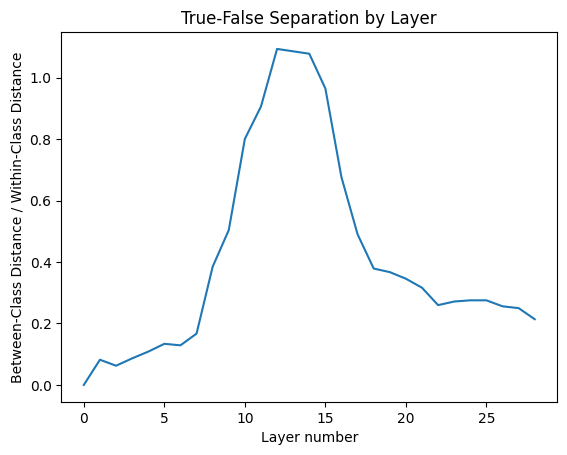

In [ ]:
from matplotlib import pyplot as plt

plt.plot(between_within_ratios)

plt.xlabel("Layer number")
plt.ylabel("Between-Class Distance / Within-Class Distance")
plt.title("True-False Separation by Layer")

The "Classes" here are simply {true_statements, false_statements}.

We are using the residual stream activations ($\textbf{r} \in \mathbb{R}^{3072} $) over the final token in input.

Letting $A(s)$ be the activation vector over the final token in input statement $s$, we have, for a layer $l$:


$$\text{trues_center}(l) = \frac{\displaystyle\sum_{s \in \text{true_statements}} {A(s)} }{|\text{true_statements}|} \qquad \qquad \qquad \qquad \quad \text{trues_mean_dist}(l) = \frac{\displaystyle\sum_{s \in \text{true_statements}} {|A(s) - \text{trues_center}(l)|} }{|\text{true_statements}|} \\[0.5in] \text{falses_center}(l) = \frac{\displaystyle\sum_{s \in \text{false_statements}} {A(s)} }{|\text{false_statements}|} \qquad \qquad \qquad \qquad \quad \text{falses_mean_dist}(l) = \frac{\displaystyle\sum_{s \in \text{false_statements}} {|A(s) - \text{falses_center}(l)|} }{|\text{false_statements}|}
\\[0.5in] {\scriptstyle\text{between_class_distance}}(l)=|\text{trues_center}(l)-\text{falses_center}(l)| \qquad  \text{within_class_distance}(l) = \frac{\scriptstyle\text{ trues_mean_dist}+\text{falses_mean_dist}}{2} $$



In [ ]:
import pickle

with open("/content/drive/My Drive/hidden_statess/true_relevant_states.pkl", "rb") as f:
  true_relevant_states = pickle.load(f)

with open("/content/drive/My Drive/hidden_statess/false_relevant_states.pkl", "rb") as f:
  false_relevant_states = pickle.load(f)